In [1]:
from __future__ import print_function
from PIL import Image, ImageChops
import math
import numpy as np
import imageio as io
from skimage import img_as_float
from skimage.measure import compare_mse as mse
from skimage.util import crop
import SimpleITK as sitk
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

#Having worked put the translations needed for a each tomogram to register the image 
#onto the binary mask (see part 2 of these notebooks) we now need to actually apply these to the volumes

point = (1.0, 1.0, 1.0)
dimension = 3 #i.e 3D

#these params where calculateed in the previous notebook from the registration process
param_0 = (0.0, 0.0, 0.0)
param_1 = (0.0, -1.0000499999999999, 0.0)
param_2 = (0.0, -1.13339, 0.0)
param_3 = (0.0, -1.0000499999999999, 0.0)
param_4 = (0.0, -1.0000499999999999, 0.0)
param_5 = (-1.0000499999999999, -1.0000499999999999, 0.0)
param_6 = (-1.0000499999999999, -1.0000499999999999, 0.0)
param_7 = (-1.0000499999999999, -1.0000499999999999, 0.0)
param_8 = (-1.0000499999999999, -1.0000499999999999, -0.8000399999999999)
param_9 = (-1.0000499999999999, -1.0000499999999999, -1.0000499999999999)
param_10 = (-1.0000499999999999, -1.0000499999999999, -1.0000499999999999)
param_11 = (0.0, 0.6666999999999998, -1.0000499999999999)
param_12 = (0.0, 2.0000999999999998, -1.0000499999999999)
param_13 = (-1.0000499999999999, 0.33335000000000004, 0.0)
param_14 = (-1.0000499999999999, 5.551115123125783e-17, 0.0)
param_15 = (-0.06667000000000001, 5.551115123125783e-17, 0.0)
param_16 = (-1.0000499999999999, 1.0000499999999999, -1.0000499999999999)
param_17 = (0.0, 1.0000499999999999, -1.0000499999999999)

#make lists
parameters = [param_0, param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8,
              param_9, param_10, param_11, param_12, param_13, param_14, param_15, param_16, param_17]
resampled_list = ['r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'r_10', 'r_11', 'r_12',
                  'r_13', 'r_14', 'r_15', 'r_16', 'r_17']

#this function executes the resampling
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkNearestNeighbor
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)
    
for x in range(0, 18):
    image = sitk.ReadImage("E:/paper_2/Registration_Volumes/cropped_TiffSaver-tomo_C%d.tif"%(x), sitk.sitkFloat32)
    translation = sitk.TranslationTransform(dimension)
    translation.SetParameters(parameters[x])
    translation.SetOffset(parameters[x])
    resampled_list[x] = resample(image, translation)

In [2]:
#Now we will load in subsequent volumes and apply binary mask & segmentation to them in a loop
#The mask was made in part 1 of these jupyter notebooks
from skimage.morphology import binary_erosion, binary_dilation, cube
from skimage.filters import gaussian
thresh_deposit_blur = 113
binary_0 = io.volread('E:/paper_2/Segmented_Volumes/vol0_binary.tif')/255
mask = 1 - binary_0
segmented_list = ['s_0', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12',
                  's_13', 's_14', 's_15', 's_16', 's_17']
for x in range(0, 18):
    vol_xa = sitk.GetArrayFromImage(resampled_list[x]).astype('uint8')
    vol_xb = vol_xa * mask
    vol_xc = gaussian(vol_xb, sigma=1.3, output=None, mode='nearest', cval=0, multichannel=False, preserve_range=True,
                       truncate=4.0)
    vol_xd = vol_xc > thresh_deposit_blur
    vol_xe = binary_erosion(vol_xd, cube(1))
    segmented_list[x] = 250*vol_xe + 100*binary_0

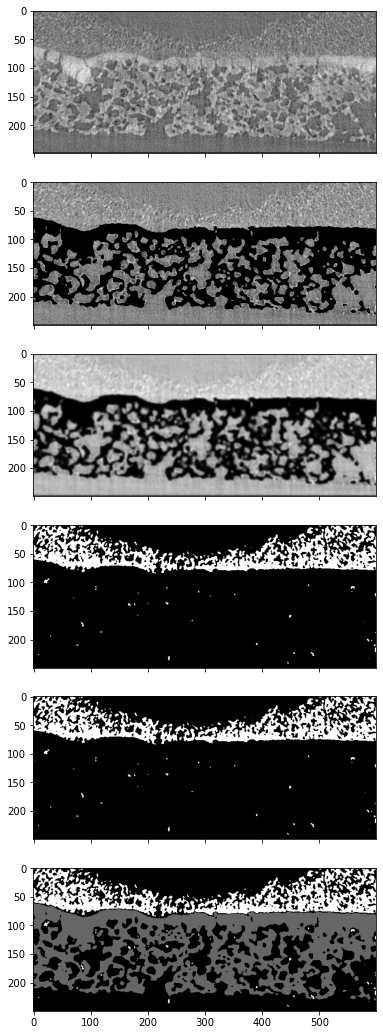

In [3]:
#We plot below a series of images which show the segmentation flow that is applied to all the volumes in the above loop
fig, axes = plt.subplots(nrows=6, ncols=1,figsize = (60, 18.4),
                       sharex=True, sharey=True)
axes[0].imshow(vol_xa[500], cmap = 'gray')
axes[1].imshow(vol_xb[500], cmap = 'gray')
axes[2].imshow(vol_xc[500], cmap = 'gray')
axes[3].imshow(vol_xd[500], cmap = 'gray')
axes[4].imshow(vol_xe[500], cmap = 'gray')
axes[5].imshow(segmented_list[17][500], cmap = 'gray')

In [6]:
for x in range(0, 18):
    io.volsave('E:/paper_2/Segmented_Volumes/Segmented_%d.tif'%(x), segmented_list[x].astype(np.uint8), format='tiff')